<a href="https://colab.research.google.com/github/dellaanima/AIFFEL_QUEST/blob/master/QUEST08/QUEST08" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16. 프로젝트: 한국어 데이터로 챗봇 만들기

## 목차

1. 데이터 수집하기
2. 데이터 전처리하기
3. SubwordTextEncoder 사용하기
4. 모델 구성하기
5. 모델 평가하기
6. 회고

## Step 1. 데이터 수집하기

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.  
[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

In [ ]:
#필요한 패키지 import
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#데이터 확인
data_path = '/aiffel/data/ChatbotData .csv'
data = pd.read_csv(data_path)

In [ ]:
data.head()

Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0

In [ ]:
len(data)

11823

In [ ]:
max_sample=11823

## Step 2. 데이터 전처리하기

In [ ]:
#null값 있는지 확인
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [ ]:
#중복데이터 확인
data.duplicated().sum()

0

아래의 함수는 정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거하여 단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제하는 것을 목표로 합니다.

In [ ]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 양쪽 공백 제거
    sentence = sentence.strip() # 공백 제거

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣,a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    pattern2 = "0-9가-힣.?!,"
    pattern1 = "가-힣a-zA-Z.?!,"
    pattern = "가-힣.?!,"
    sentence = re.sub(pattern1, ' ', sentence)
    sentence = sentence.strip()
    return sentence
print("슝=3")

슝=3


In [ ]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    for q in data['Q']:
        inputs.append(preprocess_sentence(q))
    for a in data['A']:
        outputs.append(preprocess_sentence(a))
    if len(inputs) >= max_sample:
        return inputs, outputs
    return inputs, outputs
print("슝=3")

슝=3


In [ ]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [ ]:
print('전처리 후의 222번째 질문 샘플: {}'.format(questions[221]))
print('전처리 후의 222번째 답변 샘플: {}'.format(answers[221]))

전처리 후의 222번째 질문 샘플: 공부 왜 해야 돼 ?
전처리 후의 222번째 답변 샘플: 공부하면 더 많은 선택을 할 수 있죠 .


## Step 3. SubwordTextEncoder 사용하기

### 단어장 만들기

In [ ]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [ ]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


시작 토큰과 종료 토큰에 부여된 정수를 출력

In [ ]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [ ]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [ ]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 222번째 질문 샘플: {}'.format(tokenizer.encode(questions[221])))
print('정수 인코딩 후의 222번째 답변 샘플: {}'.format(tokenizer.encode(answers[221])))

정수 인코딩 후의 222번째 질문 샘플: [549, 66, 217, 142, 2]
정수 인코딩 후의 222번째 답변 샘플: [7767, 7, 162, 1862, 35, 4, 299, 1]


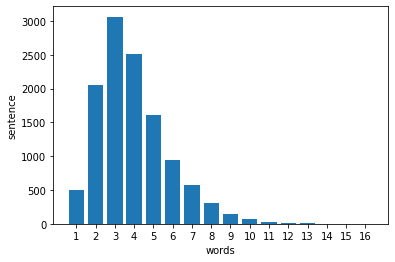

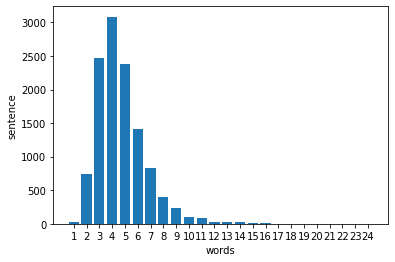

In [ ]:
import matplotlib.pyplot as plt

def visualize_sentence_lengths(sentences):
    # 각 문장의 단어 수를 세어줍니다
    word_counts = [len(sentence.split()) for sentence in sentences]

    # 최대 단어 수를 계산하여 히스토그램의 구간 수를 설정합니다
    max_word_count = max(word_counts)

    # 단어 수에 대한 히스토그램을 생성합니다
    # align='left': 이 매개변수는 히스토그램의 막대 정렬을 제어
    # rwidth=0.8: 이 매개변수는 히스토그램에서 막대의 상대적 너비를 제어
    plt.hist(word_counts, bins=range(1, max_word_count + 2), align='left', rwidth=0.8)
    plt.xlabel('words')
    plt.ylabel('sentence')
    plt.xticks(range(1, max_word_count + 1))
    plt.show()

visualize_sentence_lengths(questions)
visualize_sentence_lengths(answers)

In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 16
print(MAX_LENGTH)

16


In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_outputs, maxlen=MAX_LENGTH, padding='pre')

    return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11673
필터링 후의 답변 샘플 개수: 11673


### 교사 강요 사용하기

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## Step 4. 모델 구성하기

포지셔널 인코딩 레이어 구현

In [ ]:
#포지셔널 행렬을 직접 구현
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


 스케일드 닷 프로덕트 어텐션 함수 구현

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

        # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print("슝=3")

슝=3


MultiHeadAttention 구현

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
print("슝=3")

슝=3


패딩 마스킹 구현

In [ ]:
#패딩 마스킹을 구현한 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [ ]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


인코더 만들기


In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


디코더 만들기


In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
    d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


transformer 만들기

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


### 모델 생성

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.4 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

손실 함수

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)
print("슝=3")

슝=3


3. 커스텀 된 학습률(Learning rate)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):

        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

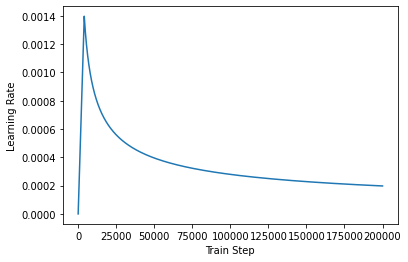

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

모델 컴파일

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [ ]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
183/183 [==============================] - 12s 35ms/step - loss: 4.3030 - accuracy: 0.0729
Epoch 2/100
183/183 [==============================] - 6s 34ms/step - loss: 3.3677 - accuracy: 0.1820
Epoch 3/100
183/183 [==============================] - 6s 34ms/step - loss: 2.6625 - accuracy: 0.1967
Epoch 4/100
183/183 [==============================] - 6s 34ms/step - loss: 2.4130 - accuracy: 0.2041
Epoch 5/100
183/183 [==============================] - 6s 34ms/step - loss: 2.2884 - accuracy: 0.2089
Epoch 6/100
183/183 [==============================] - 6s 34ms/step - loss: 2.2018 - accuracy: 0.2130
Epoch 7/100
183/183 [==============================] - 6s 34ms/step - loss: 2.1275 - accuracy: 0.2177
Epoch 8/100
183/183 [==============================] - 6s 34ms/step - loss: 2.0481 - accuracy: 0.2234
Epoch 9/100
183/183 [==============================] - 6s 34ms/step - loss: 1.9579 - accuracy: 0.2287
Epoch 10/100
183/183 [==============================] - 6s 34ms/step - loss: 1.85

## STEP5. 모델 평가하기

In [ ]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    print("-------------------")

    return predicted_sentence
print("슝=3")

슝=3


### 한글만 정규 표현식에 넣어서 진행 했을 때 결과
pattern="가-힣.?!,"

In [ ]:
sentence_generation('한가지 소원이 있다면?')
sentence_generation('심심해?')
sentence_generation("점심메뉴 선택해줘")
sentence_generation('여행 떠나고 싶어')
sentence_generation('TV엔 어떤 프로그램이 나오니?')
sentence_generation('1년뒤에 어떻게 바뀔까요?')
sentence_generation('12월에 어디를 가면 좋을까?')

입력 : 한가지 소원이 있다면?
출력 : 가운데서 만나거나 돌아가면서 희생을 하죠 .
-------------------
입력 : 심심해?
출력 : 노래 불러 드릴까요 ? 북치기박치기박치기 헥헥
-------------------
입력 : 점심메뉴 선택해줘
출력 : 저도 제 마음대로 되면 더 바랄 게 없겠네요 .
-------------------
입력 : 여행 떠나고 싶어
출력 : 큰 꿈여행을 떠나 꿈여행을 하고 아무렇지도 않게 같이 꿈보세요 .
-------------------
입력 : TV엔 어떤 프로그램이 나오니?
출력 : 항상 확실한 의사표시를 했는데도 그렇다는 건 이기적인 것 같아요 .
-------------------
입력 : 1년뒤에 어떻게 바뀔까요?
출력 : 평소에 볼 수 없었던 특별한 모습으로 색다른 데이트를 제안해보세요 .
-------------------
입력 : 12월에 어디를 가면 좋을까?
출력 : 알아가는 단계니 디테일한 건 말 안해도 돼요 .
-------------------


'알아가는 단계니 디테일한 건 말 안해도 돼요 .'

### 한글과 영어를 정규 표현식에 넣어서 진행 했을 때 결과
pattern1 = "가-힣a-zA-Z.?!,"

In [ ]:
sentence_generation('한가지 소원이 있다면?')
sentence_generation('심심해?')
sentence_generation("점심메뉴 선택해줘")
sentence_generation('여행 떠나고 싶어')
sentence_generation('TV엔 어떤 프로그램이 나오니?')
sentence_generation('sd카드 사고 싶어')
sentence_generation('1년뒤에 어떻게 바뀔까요?')
sentence_generation('12월에 어디를 가면 좋을까?')

입력 : 한가지 소원이 있다면?
출력 : 요즘 상영하는 영화나 맛집부터 시작해보는 것도 좋을 듯합니다 .
-------------------
입력 : 심심해?
출력 : 친구들과 연락해보세요 . 당장 그럴 거예요 . 무엇이 그럴 수 있어요 . 무엇이 있어요 .
-------------------
입력 : 점심메뉴 선택해줘
출력 : 돌아보면 다그치지 않고 화내지 않아도 될 일이었을 거예요 .
-------------------
입력 : 여행 떠나고 싶어
출력 : 좋은 생각이에요 . 좋은 생각이에요 . 혼자하는 여행은 기분전환에 좋은 생각이에요 .
-------------------
입력 : TV엔 어떤 프로그램이 나오니?
출력 : 수학 공식처럼 정의 내릴 수 있다면 그런 거예요 .
-------------------
입력 : sd카드 사고 싶어
출력 : 거울을 보면서 얼굴 망가뜨리기 놀이 해 보신 적 있으세요 ? 의외로 재미 있어요 .
-------------------
입력 : 1년뒤에 어떻게 바뀔까요?
출력 : 일부로 부추기면 가끔 안 좋은 결과가 나오기도 해요 .
-------------------
입력 : 12월에 어디를 가면 좋을까?
출력 : 보통 남자들은 아무 여자에게나 하트를 붙여서 말하지 않아요 .
-------------------


'보통 남자들은 아무 여자에게나 하트를 붙여서 말하지 않아요 .'

### 숫자, 한글을 정규 표현식에 넣어서 진행 했을 때 결과
pattern2 = "0-9가-힣.?!,"

In [ ]:
sentence_generation('한가지 소원이 있다면?')
sentence_generation('심심해?')
sentence_generation("점심메뉴 선택해줘")
sentence_generation('여행 떠나고 싶어')
sentence_generation('TV엔 어떤 프로그램이 나오니?')
sentence_generation('sd카드 사고 싶어')
sentence_generation('1년뒤에 어떻게 바뀔까요?')
sentence_generation('12월에 어디 가면 좋으니?')

입력 : 한가지 소원이 있다면?
출력 : 영화관 공원 놀이동산 바다 산 축제 도서관 엄청 많죠 .
-------------------
입력 : 심심해?
출력 : 노래 불러 드릴까요 ? 북치기박치기박치기 헥헥
-------------------
입력 : 점심메뉴 선택해줘
출력 : 화학 물질이 접촉하는 것처럼 반응이 일어나서 완전히 바뀌게 되죠 .
-------------------
입력 : 여행 떠나고 싶어
출력 : 저도 만날 사람 만날 때 같이 가는 건 같이 가는 사람은 안됩니다 .
-------------------
입력 : TV엔 어떤 프로그램이 나오니?
출력 : 마음 먹은 것만으로도 절반을 해낸 거라 생각해요 .
-------------------
입력 : sd카드 사고 싶어
출력 : 목록에서 없애는 건 어떨까요 . 눈에서 멀어지면 미련도 덜해집니다 .
-------------------
입력 : 1년뒤에 어떻게 바뀔까요?
출력 : 마음은 마음대로 되지 않아요 . 이 고민지다고 생각하는 사람은 좋겠네요 .
-------------------
입력 : 12월에 어디 가면 좋으니?
출력 : 사랑한다면 자존심을 굽힐 줄도 알아야 겠죠 .
-------------------


'사랑한다면 자존심을 굽힐 줄도 알아야 겠죠 .'

## 회고

- 한국어로 챗봇 만들기 프로젝트를 진행하면서 트랜스포머의 모델에 대한 이해도가 높지 않아서 중점을 데이터 전처리에 두고 프로젝트를 진행했다. 프로젝트를 진행하면서 epoch의 변화와, 단어 토크나이징에 변화를 주면서 모델을 학습시켜봤다.  
- 먼저 epoch에 대해선 10, 50, 100, 200으로 학습을 진행하였는데, 10, 50 보다는 100일 때, 문장 답변의 퀄리티가 좋았고, 200일 때는 100과 비교했을 때, 좋았던 경우도 있고, 부정확한 경우도 있었다. 그래서 200일 때는 오버피팅이 발생했다고 생각했고, epoch는 100으로 설정해서 학습을 진행했다.  
- 다음으로 단어 토크나이징은 3가지로 나누어서 진행했는데, 결론은 영어와, 숫자는 데이터가 너무 적어서 결과가 좋지 못했다. 영어는 부정확한 답변을 알려주었고, 숫자는 그나마 영어 보다는 좋았지만, 그래도 부정확한 답변을 알려주었다. 그래서 이 모델을 학습시킨다면, 질문을 한글위주로 하는것이 좋을것 같다. 아니면 데이터를 추가해서 학습시키는것이 좋을것 같다.  
- 마지막으로 데이터셋에 대해 살펴 보았는데, 문장 구조가 비슷한 경우가 많았고, 데이터도 많지 않다보니, 학습시킨 내용과 비슷한 질문을 했을 땐 답변을 잘 해주었지만, 어려운? 질문을 했을 땐 답변을 잘 하지 못하는 결과를 보여주었다. 학습과 관련해서 정확도가 높다고 무조건 좋은 답변을 해주는 것은 아니었다(정확도가 0.3과 0.5는 질문의 답변 퀄리티가 차이가 낫지만, 0.5와 0.6의 정확도에 대한 질문의 퀄리티 차이는 거의 없었다.).
- 성능을 높이고자, 하이퍼 파라미터를 변경해 보았지만, 사용하는 데이터 셋의 한계가 있기도 했고, 최적의 하이퍼파라미터를 구하기(ex gridsearch)엔 시간이 부족하여 실행해보지 못했다. 추후에 트랜스포머에 대해 좀더 배워보고 데이터 셋에 알맞는 학습을 진행해보겠다.
